Copyright (c) 2025 Graphcore Ltd. All rights reserved.

# Optimal Formats Demo

A simplified reproduction of headline results from [Optimal Formats for Weight Quantisation](https://arxiv.org/abs/2505.12988).

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import tensor

import weight_formats.experiments as E
import weight_formats.experiments.token_prediction as ET
import weight_formats.fit as F
import weight_formats.quantisation as Q

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
matplotlib.rcParams.update({
    "figure.figsize": (6, 4), "legend.edgecolor": "none",
    "axes.spines.top": False, "axes.spines.right": False,
})

## Simulation - block scaling and compression

For iid data from a Student-t distribution, we observe that block absmax scaling can outperform RMS scaling, even using $\sqrt[3]{\mathrm{p}}$ and Lloyd-Max quantisers. Since block scaling outperforms these fixed-length formats, but underperforms a uniform quantiser with lossless compression, it seems to exploit a form of variable-length coding.

Here we reproduce/approximate Figure 4 (right), adding Lloyd-Max.

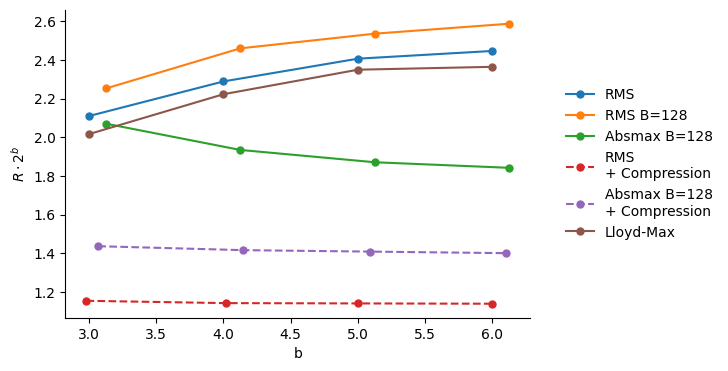

In [ ]:
t_df = 5
samples = 2**20
B = 128
b_base = torch.arange(3, 6.01, 1)

theta = torch.distributions.StudentT(tensor(t_df, device=DEVICE, dtype=torch.float32)).sample((samples,))

def show(fmt_factory, label):
    fmts = [fmt_factory(b) for b in b_base.tolist()]
    b = tensor([fmt.count_bits_tensor(theta) / theta.nelement() for fmt in fmts])
    R = torch.stack([Q.qrmse_norm(fmt, theta) for fmt in fmts]).cpu()
    plt.plot(b, R * 2**b, marker="o", ms=5, label=label, ls="--" if "Compression" in label else "-")

show(lambda b: Q.LinearScalingFormat(Q.crd_t(b, df=t_df), Q.BFLOAT16, (None,), "rms"), "RMS")
show(lambda b: Q.LinearScalingFormat(Q.crd_t(b, df=t_df), Q.BFLOAT16, (128,), "rms"), f"RMS B={B}")
show(lambda b: Q.LinearScalingFormat(Q.crd_block_t(b, B, df=t_df), Q.BFLOAT16, (128,), "absmax"), f"Absmax B={B}")
show(lambda b: F.Scaled(b, "int", Q.BFLOAT16, (None,), "rms", compressor="optimal").fit(theta), "RMS\n+ Compression")
show(lambda b: F.Scaled(b, "int", Q.BFLOAT16, (128,), "absmax", compressor="optimal").fit(theta), f"Absmax B={B}\n+ Compression")
show(lambda b: Q.lut_lloyd_max(theta, b, 1e-4), f"Lloyd-Max")

plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.ylabel(r"$R \cdot 2^b$")
plt.xlabel("b");

## Experiments - variable-length vs fixed-length

In our main experiments on direct-cast inference, we demonstrate that the most effective formats use some form of variable-length coding: lossless compression, block (or channel) absmax scaling or 0.1% sparse outlier removal.

Here we reproduce a similar sweep to Figure 1. However, for sake of speed, we use Llama-3.2-1B in place of Llama-3.1-8B and test only a single symmetry variant (symmetric) rather than picking the better of (symmetric, asymmetric).

Note: this takes a few minutes on first run.

In [60]:
force_rerun = False

tests = []
for b in [3, 4, 5]:
    for block_shape, scaling, sparse_ratio, compressor in [
        ((None, None), "rms", 0, "optimal"),
        ((None, None), "rms", 2**-10, None),
        ((1, 128), "absmax", 0, None),
        ((None, None), "absmax", 0, None),
        ((None, None), "rms", 0, None),
    ]:
        tests.append(ET.QuantiseFixed(F.Scaled(
            b, "t" if compressor is None else "int",
            Q.BFLOAT16, block_shape, scaling,
            sparse_format=Q.BFLOAT16, sparse_ratio=sparse_ratio, compressor=compressor,
        )))

if len(E.runs("demo")) == len(tests) and not force_rerun:
    print("The test has already run - skipping")
else:
    for run in E.runs("demo"):
        E.delete_run(run.id)
    ET.run_sweep([ET.Run("demo", test, "meta-llama/Llama-3.2-1B") for test in tests])

100%|██████████| 1/1 [00:29<00:00, 29.45s/it]


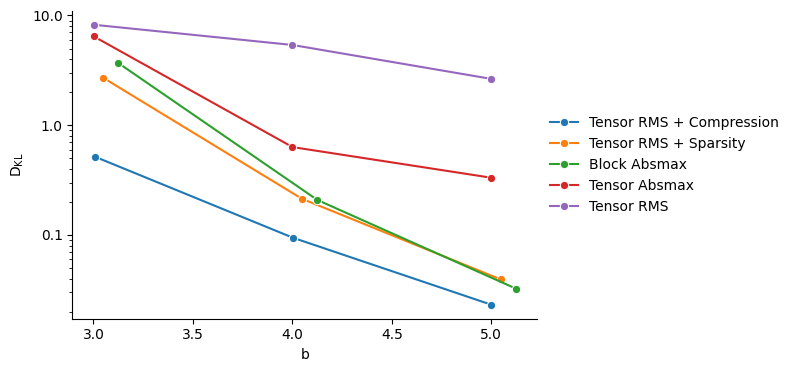

In [62]:
def load(run):
    fmt = run.config.test.fmt
    name = {(None, None): "Tensor", (1, 128): "Block"}[fmt.block_shape]
    name += " " + dict(rms="RMS", absmax="Absmax")[fmt.scaling]
    if fmt.compressor:
        name += " + Compression"
    if fmt.sparse_ratio:
        name += " + Sparsity"
    return dict(
        name=name,
        b=run.summary.bits_per_param,
        kl_div=tensor(run.summary.kl_div).mean().item(),
    )

df = pd.DataFrame.from_records(map(load, E.runs("demo")))
ax = sns.lineplot(data=df, y="kl_div", x="b", hue="name", marker="o")
ax.set_yscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter("{x}")
ax.set_ylabel(r"$\mathrm{D_{KL}}$");